In [1]:
import pandas as pd 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost


2023-03-30 19:10:20.027968: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Import findspark and initialize. 
import findspark
findspark.init()

In [3]:
# Import packages
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import StructType,StructField,StringType, DateType,IntegerType

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/30 19:11:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url = "https://project444.s3.us-west-1.amazonaws.com/healthcare-dataset-stroke-data.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("healthcare-dataset-stroke-data.csv"), sep=",", header=True)

In [5]:
df.show()

+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male| 67|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female| 61|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male| 80|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female| 49|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female| 79|           1|            0|         Yes|Self

In [6]:
pandasDF = df.toPandas()
pandasDF

id  gender age hypertension heart_disease ever_married  \
0      9046    Male  67            0             1          Yes   
1     51676  Female  61            0             0          Yes   
2     31112    Male  80            0             1          Yes   
3     60182  Female  49            0             0          Yes   
4      1665  Female  79            1             0          Yes   
...     ...     ...  ..          ...           ...          ...   
5105  18234  Female  80            1             0          Yes   
5106  44873  Female  81            0             0          Yes   
5107  19723  Female  35            0             0          Yes   
5108  37544    Male  51            0             0          Yes   
5109  44679  Female  44            0             0          Yes   

          work_type Residence_type avg_glucose_level   bmi   smoking_status  \
0           Private          Urban            228.69  36.6  formerly smoked   
1     Self-employed          Rural            202.21   N/A     never smoked   
2           Private          Rural            105.92  32.5     never smoked   
3           Private          Urban            171.23  34.4           smokes   
4     Self-employed          Rural            174.12    24     never smoked   
...             ...            ...               ...   ...              ...   
5105        Private          Urban             83.75   N/A     never smoked   
5106  Self-employed          Urban             125.2    40     never smoked   
5107  Self-employed          Rural             82.99  30.6     never smoked   
5108        Private          Rural            166.29  25.6  formerly smoked   
5109       Govt_job          Urban             85.28  26.2          Unknown   

     stroke  
0         1  
1         1  
2         1  
3         1  
4         1  
...     ...  
5105      0  
5106      0  
5107      0  
5108      0  
5109      0  

[5110 rows x 12 columns]

In [8]:
pandasDF = pandasDF.astype({"id": int, "hypertension": int, "heart_disease": int, "stroke": int })

In [9]:
pandasDF = pandasDF.astype({'avg_glucose_level': float})

In [10]:
pandasDF['bmi'] = pandasDF['bmi'].str.replace('N/A','NaN')

In [11]:
pandasDF = pandasDF.astype({'bmi': float})

In [13]:
stroke_df = pandasDF

In [15]:
pd.set_option("display.max_rows", None)
stroke_df.head()
stroke_df.dtypes
stroke_df['bmi'] = stroke_df['bmi'].fillna(0)

In [16]:
stroke_df.isna().sum()


id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [17]:
stroke_df.nunique()


id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   419
smoking_status          4
stroke                  2
dtype: int64

In [18]:
stroke_df.drop(columns='id', inplace=True)
stroke_df.head()

gender age  hypertension  heart_disease ever_married      work_type  \
0    Male  67             0              1          Yes        Private   
1  Female  61             0              0          Yes  Self-employed   
2    Male  80             0              1          Yes        Private   
3  Female  49             0              0          Yes        Private   
4  Female  79             1              0          Yes  Self-employed   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban             228.69  36.6  formerly smoked       1  
1          Rural             202.21   0.0     never smoked       1  
2          Rural             105.92  32.5     never smoked       1  
3          Urban             171.23  34.4           smokes       1  
4          Rural             174.12  24.0     never smoked       1

In [19]:
df_dummies = pd.get_dummies(stroke_df[['gender','ever_married', 'work_type','Residence_type', 'smoking_status']])
stroke_df_copy = stroke_df[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']]
merged_data = pd.concat([stroke_df_copy, df_dummies], axis= 1)
merged_data.head()
X = merged_data.drop('stroke', axis=1).values
y = merged_data['stroke'].values


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [21]:
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [22]:
len(X_train[0])

21

In [23]:
nn = tf.keras.models.Sequential()
number_of_input_features = len(X_train[0])
hidden_neuron1 = 100 
hidden_neuron2 = 50 
hidden_neuron3 = 30 

nn.add(tf.keras.layers.Dense(units = hidden_neuron1, activation='relu', input_dim = number_of_input_features))
nn.add(tf.keras.layers.Dense(units = hidden_neuron2, activation='sigmoid'))
nn.add(tf.keras.layers.Dense(units = hidden_neuron3, activation='sigmoid'))
nn.add(tf.keras.layers.Dense(units = 1, activation='sigmoid'))
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2200      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 30)                1530      
                                                                 
 dense_3 (Dense)             (None, 1)                 31        
                                                                 
Total params: 8,811
Trainable params: 8,811
Non-trainable params: 0
_________________________________________________________________


In [24]:
nn.compile(loss= 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [25]:
nn.fit(X_train_scaled, y_train, epochs = 100)

Epoch 1/100
120/120 [==============================] - 1s 1ms/step - loss: 0.3793 - accuracy: 0.8262
Epoch 2/100
120/120 [==============================] - 0s 1ms/step - loss: 0.1832 - accuracy: 0.9559
Epoch 3/100
120/120 [==============================] - 0s 930us/step - loss: 0.1761 - accuracy: 0.9559
Epoch 4/100
120/120 [==============================] - 0s 938us/step - loss: 0.1704 - accuracy: 0.9559
Epoch 5/100
120/120 [==============================] - 0s 952us/step - loss: 0.1627 - accuracy: 0.9559
Epoch 6/100
120/120 [==============================] - 0s 939us/step - loss: 0.1551 - accuracy: 0.9559
Epoch 7/100
120/120 [==============================] - 0s 927us/step - loss: 0.1495 - accuracy: 0.9559
Epoch 8/100
120/120 [==============================] - 0s 942us/step - loss: 0.1454 - accuracy: 0.9559
Epoch 9/100
120/120 [==============================] - 0s 929us/step - loss: 0.1413 - accuracy: 0.9559
Epoch 10/100
120/120 [==============================] - 0s 936us/step - loss:

In [26]:
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose =2)
print(f"Model_loss: {model_loss}, Model_accuracy: {model_accuracy}")

40/40 - 0s - loss: 0.2919 - accuracy: 0.9319 - 166ms/epoch - 4ms/step
Model_loss: 0.29191190004348755, Model_accuracy: 0.9319248795509338


In [27]:
xgb_model = xgboost.XGBClassifier()
xgb_model = xgb_model.fit(X_train_scaled, y_train)
predictions = xgb_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
accuracy

0.9327073552425665

In [28]:
forest_model = RandomForestClassifier(n_estimators= 398, random_state= 42)
forest_model = forest_model.fit(X_train_scaled, y_train)
predictions = forest_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, predictions)
accuracy 

0.9381846635367762

In [29]:
## Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[1198,    0],
       [  79,    1]])

In [30]:
## Classification Report
from sklearn.metrics import classification_report
target_names = ["0", "1"]
print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1198
           1       1.00      0.01      0.02        80

    accuracy                           0.94      1278
   macro avg       0.97      0.51      0.50      1278
weighted avg       0.94      0.94      0.91      1278



In [31]:
# Random Forests in sklearn will automatically calculate feature importance
importances = forest_model.feature_importances_
# We can sort the features by their importance
features = merged_data.drop('stroke', axis=1)
sorted(zip(forest_model.feature_importances_, features.columns), reverse=True)

[(0.2555301727843203, 'avg_glucose_level'),
 (0.23735061132970622, 'age'),
 (0.22071457189583477, 'bmi'),
 (0.027891766926275298, 'hypertension'),
 (0.026707211695481785, 'heart_disease'),
 (0.02082551215118089, 'smoking_status_never smoked'),
 (0.020502583049011768, 'work_type_Private'),
 (0.019906146639983083, 'work_type_Self-employed'),
 (0.01988296365530764, 'gender_Female'),
 (0.019852275903664677, 'Residence_type_Urban'),
 (0.019692270650587113, 'gender_Male'),
 (0.018997089604537932, 'smoking_status_formerly smoked'),
 (0.018930864453701703, 'smoking_status_smokes'),
 (0.01892672662440686, 'Residence_type_Rural'),
 (0.017582253621402227, 'smoking_status_Unknown'),
 (0.013330040219789388, 'work_type_Govt_job'),
 (0.010968327055775112, 'ever_married_No'),
 (0.010950972325912014, 'ever_married_Yes'),
 (0.001445779478056669, 'work_type_children'),
 (1.1859935064607554e-05, 'work_type_Never_worked'),
 (0.0, 'gender_Other')]

<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

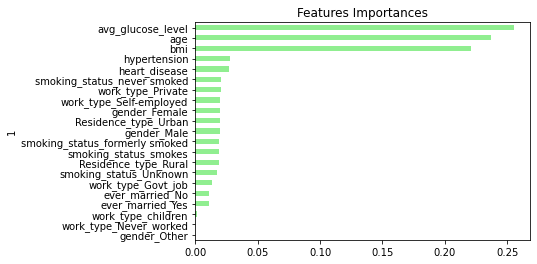

In [35]:
importances_df = pd.DataFrame(sorted(zip(forest_model.feature_importances_, features.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)